<a href="https://colab.research.google.com/github/Richardjmorton/colab/blob/master/notebooks/temperature_maps_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepEM: A Deep Learning Approach for DEM Inversion
In this notebook we re-work the DeepEM code to use Tensorflow. The original notebook in pytorch is avilable at [https://github.com/PaulJWright/DeepEM](https://github.com/PaulJWright/DeepEM). Hence, this notebook also demonstrate straining (and testing) DeepEM, a deep-learning approach for DEM inversion.

This verison is authored by Richard Morton (Northumbria University, UK).


Original credit:

 Paul Wright$^{1}$, Mark Cheung$^{1,2}$, Rajat Thomas$^{3}$, Richard Galvez$^{4}$, Alexandre Szenicer$^{5}$, Meng Jin$^{2,6}$, Andrés Muñoz-Jaramillo$^{7}$, and David Fouhey$^{8}$

$^{1}$Stanford University;
$^{2}$Lockheed Martin Solar and Astrophysics Laboratory;
$^{3}$University of Amsterdam;
$^{4}$5x5 Technologies Inc;
$^{5}$University of Oxford;
$^{6}$SETI Institute;
$^{7}$SouthWest Research Institute;
$^{8}$University of Michigan

---

## Introduction

The intensity observed through optically-thin <i>SDO</i>/AIA filters (94 Å, 131 Å, 171 Å, 193 Å, 211 Å, 335 Å) can be related to the temperature distribution of the solar corona (the differential emission measure; DEM) as

\begin{equation}
g_{i} = \int_{T} K_{i}(T) \xi(T) dT \, .
\end{equation}

In this equation, $g_{i}$ is the DN s$^{-1}$ px$^{-1}$ value in the $i$th SDO/AIA channel. This intensity corresponds to the $K_{i}(T)$ temperature response function, and the DEM, $\xi(T)$, is in units of cm$^{-5}$ K$^{-1}$. The matrix formulation of this integral equation can be represented in the form $\vec{g} = {\bf K}\vec{\xi}$, however this problem is an ill-posed inverse problem, and any attempt to directly recover $\vec{\xi}$ leads to significant noise amplification. 

There are numerous methods to tackle mathematical problems of this kind, and there are an increasing number of methods in the literature for recovering the differential emission measure from <i>SDO</i>/AIA observations, including methods based techniques such as Tikhonov Regularisation (<a href="https://doi.org/10.1051/0004-6361/201117576">Hannah & Kontar 2012</a>), on the concept of sparsity (<a href="https://doi.org/10.1088/0004-637X/807/2/143">Cheung <i>et al</i> 2015</a>).

Here we present a deep learning approach for DEM Inversion. <i>For this notebook</i>, DeepEM is a trained on one set of <i>SDO</i>/AIA observations (six optically thin channels; 6 x N x N) and DEM solutions (in 18 temperature bins from log$_{10}$T = 5.5 - 7.2, 18 x N x N; Cheung <i>et al</i> 2015) at a resolution of 512 x 512 (N = 512) using a 1x1 2D Convolutional Neural Network with a single hidden layer.

The DeepEM method presented here takes every DEM solution with no regards to the quality or existence of the solution. As will be demonstrated, when this method is trained with a single set images and DEM solutions, the DeepEM solutions have a similar fidelity to Basis Pursuit (with a significantly increased computation speed), and additionally, the DeepEM solutions find positive solutions at every pixel, and reduced noise in the DEM solutions.

### Table of Contents

The notebook is set out as follows:

1. Setting up the notebook <br>
2. Training
    * Step 1: Obtain Data and Basis Pursuit Solutions for Training <br>
    * Step 2: Define the Model <br>
    * Step 3: Train the Model <br>
3. Testing the Model <br>
4. Synthesize <i>SDO</i>/AIA Observations
5. Doing this on your data <br>
6. Discussion 

## 1. Setting up the notebook

In [1]:
!pip install tensorflow_addons
!pip install git+https://github.com/henrysky/astroNN.git

     |████████████████████████████████| 1.1 MB 4.2 MB/s 
  Cloning https://github.com/henrysky/astroNN.git to /tmp/pip-req-build-2b2hs3c9
  Running command git clone -q https://github.com/henrysky/astroNN.git /tmp/pip-req-build-2b2hs3c9
     |████████████████████████████████| 4.5 MB 4.2 MB/s 
     |████████████████████████████████| 832 kB 37.5 MB/s 
     |████████████████████████████████| 54 kB 2.4 MB/s 
     |████████████████████████████████| 3.6 MB 26.7 MB/s 
  Created wheel for astroNN: filename=astroNN-1.1.dev0-py3-none-any.whl size=9330001 sha256=816d0c5026dbf3988c17a51f579912a438b3c58fd8b6e4b95494f55ea03ffae7
  Stored in directory: /tmp/pip-ephem-wheel-cache-ucl8n5mz/wheels/62/c3/46/cab22f46819e657a7c34e0fbb737c388b8f3a7271eef0e589e
Successfully built astroNN


In [1]:
# This notebook has been written in Tensorflow
%matplotlib inline

import os
import time


import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dropout, InputLayer, LeakyReLU, Dense
from tensorflow.keras.models import Sequential, Model

import tensorflow.keras as tfk

import tensorflow_addons as tfa

import matplotlib.pyplot as plt



In [10]:
from google.cloud import storage
from google.colab import auth

auth.authenticate_user()

In [12]:
bucket_name = "fdl-deepem"

storage_client = storage.Client.create_anonymous_client()
bucket = storage_client.bucket(bucket_name)

In [13]:
gpu = tf.config.list_physical_devices('GPU')
if len(gpu) == 0:
    print(
        f'GPU is unavailable. If you are running this notebook on Colab, go to Runtime > Change runtime type, and set "GPU"'
    )
else:
    print("GPU is available")

GPU is available


In [14]:
### scaling

In [15]:
def em_scale(y):
    return np.sqrt(y / 1e25)


def em_unscale(y):
    return 1e25 * (y * y)


def img_scale(x):
    x2 = x
    bad = np.where(x2 <= 0.0)
    x2[bad] = 0.0
    return np.sqrt(x2)


def img_unscale(x):
    return x * x

## 2. Training
### Step 1: Obtain Data and Basis Pursuit Solutions for Training

We first load the <i>SDO</i>/AIA images and Basis Pursuit DEM maps.

N.B. While this simplified version of DeepEM has been trained on DEM maps from Basis Pursuit (Cheung <i>et al</i> 2015), we actively encourage the readers to try their favourite method for DEM inversion! 

In [16]:
def list_files(bucket_name):
    """List all files in GCP bucket."""
    files = bucket.list_blobs()
    fileList = [file.name for file in files if "." in file.name]
    return fileList

In [17]:
dir = "fdl-deepem2"
os.mkdir(dir)


FileExistsError: ignored

In [18]:
files = list_files(bucket_name)
for file in files:
    blob = bucket.blob(file)
    blob.download_to_filename(os.path.join(dir, file))
    print(f"downloaded {file} to {dir}")

downloaded AIA_DEM_2011-01-27.aia.npy to fdl-deepem2
downloaded AIA_DEM_2011-01-27.emcube.npy to fdl-deepem2
downloaded AIA_DEM_2011-01-27.status.npy to fdl-deepem2
downloaded AIA_DEM_2011-02-22.aia.npy to fdl-deepem2
downloaded AIA_DEM_2011-02-22.emcube.npy to fdl-deepem2
downloaded AIA_DEM_2011-02-22.status.npy to fdl-deepem2
downloaded AIA_DEM_2011-03-20.aia.npy to fdl-deepem2
downloaded AIA_DEM_2011-03-20.emcube.npy to fdl-deepem2
downloaded AIA_DEM_2011-03-20.status.npy to fdl-deepem2
downloaded AIA_Resp.npy to fdl-deepem2


In [19]:
aia_files = ["AIA_DEM_2011-01-27", "AIA_DEM_2011-02-22", "AIA_DEM_2011-03-20"]
em_cube_files = aia_files
status_files = aia_files
for k, (afile, emfile) in enumerate(zip(aia_files, em_cube_files)):
    afile_name = afile + ".aia.npy"
    emfile_name = emfile + ".emcube.npy"
    status_name = emfile + ".status.npy"
    if k == 0:
        X = np.load(os.path.join(dir, afile_name))
        y = np.load(os.path.join(dir, emfile_name))
        status = np.load(os.path.join(dir, status_name))

        X = np.zeros((len(aia_files), X.shape[0], X.shape[1], X.shape[2]))
        y = np.zeros((len(em_cube_files), y.shape[0], y.shape[1], y.shape[2]))
        status = np.zeros((len(status_files), status.shape[0], status.shape[1]))

        nlgT = y.shape[0]
        lgtaxis = np.arange(y.shape[1]) * 0.1 + 5.5

    X[k] = np.load(os.path.join(dir, afile_name))
    y[k] = np.load(os.path.join(dir, emfile_name))
    status[k] = np.load(os.path.join(dir, status_name))

### Step 2: Define the Model

We first define the model as a 1x1 2D Convolutional Neural Network (CNN) with a kernel size of 1x1 and a single hidden layer. The model accepts a data cube of 6 x N x N (<i>SDO</i>/AIA data), and returns a data cube of 18 x N x N (DEM). When trained, this will transform the input (each pixel of the 6 <i>SDO</i>/AIA channels; 6 x 1 x 1) to the output (DEM at each pixel; 18 x 1 x 1).

In [ ]:
reg = tf.keras.regularizers.l2(l2=1e-9)

kwargs = {'kernel_size': 1} #, 'activation': 'relu'}#, 'kernel_regularizer': reg }

model = Sequential([
    InputLayer(input_shape=(512, 512, 6)),
    Conv2D(300, **kwargs),
    LeakyReLU(alpha=1e-2),
    Conv2D(300, **kwargs ),
    LeakyReLU(alpha=1e-2),
    Conv2D(18, **kwargs),
    LeakyReLU(alpha=1e-2) ]
)

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 512, 512, 300)     2100      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 512, 512, 300)     0         
                                                                 
 conv2d_25 (Conv2D)          (None, 512, 512, 300)     90300     
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 512, 512, 300)     0         
                                                                 
 conv2d_26 (Conv2D)          (None, 512, 512, 18)      5418      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 512, 512, 18)      0         
                                                                 
Total params: 97,818
Trainable params: 97,818
Non-trai

### Step 3: Train the Model

For training, we select one <i>SDO</i>/AIA data cube (6 x 512 x 512) and the corresponding Basis Pursuit DEM output (18 x 512 x 512). In the case presented here, we train the CNN on an image of the Sun obtained on the 27 Jan  2011; validate on an image of the Sun obtained one synodic rotation later (+26 days; 22-02-2011); and finally test on an image another 26 days later (20-03-2011).

In [20]:
X = img_scale(X)
y = em_scale(y)

X_train = np.transpose(X[0:1], (0, 2, 3, 1))
y_train = np.transpose(y[0:1], (0, 2, 3, 1))

X_val = np.transpose(X[1:2], (0, 2, 3, 1))
y_val = np.transpose(y[1:2], (0, 2, 3, 1))

X_test = np.transpose(X[2:3], (0, 2, 3, 1))
y_test = np.transpose(y[2:3], (0, 2, 3, 1))

y_train.shape

(1, 512, 512, 18)

#### Plotting SDO/AIA Observations ${\it vs.}$ Basis Pursuit DEM bins

For the test data set, the <i>SDO</i>/AIA images for 171 Å, 211 Å, and 94 Å, and the corresponding DEM bins near the peak sensitivity in these relative isothermal channel (log$_{10}$T = 5.9, 6.3, 7.0) are shown in Figure 1. Figure 1 shows a set of <i>SDO</i>/AIA images (171 Å, 211 Å, and 94 Å [top, left to right]) with the corresponding DEM maps (bottom) for temperature bins there are near the peak sensitivity of the <i>SDO</i>/AIA channel. Furthermore, it is clear from the DEM maps that a number of pixels that are $zero$. These pixels are primarily located off-disk, but there are a number of pixels on-disk that show this behaviour.

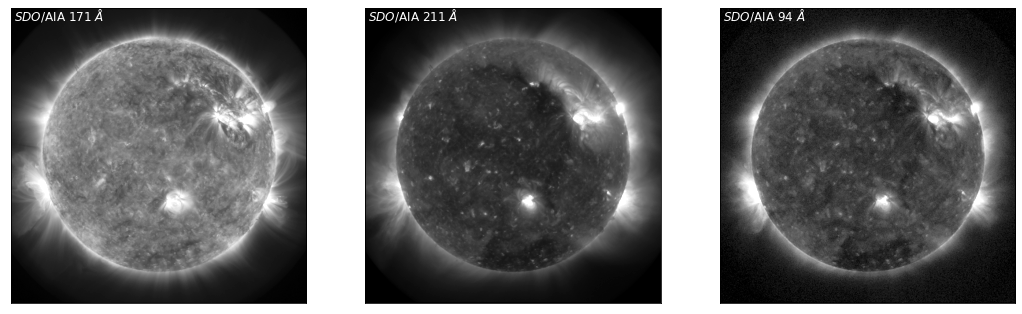

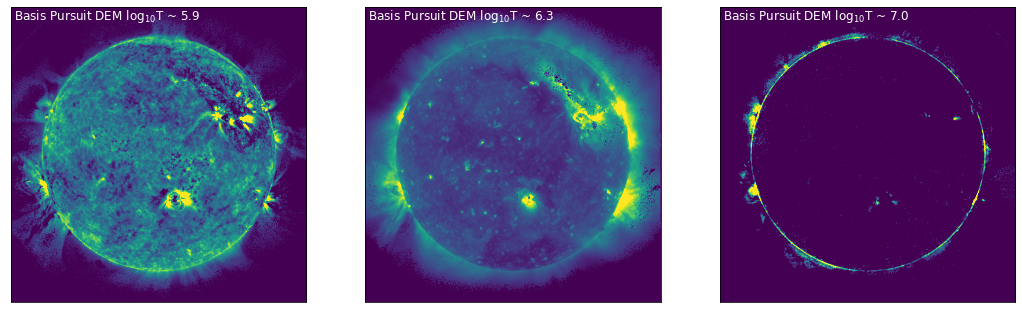

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(9 * 2, 9))

ax[0].imshow(X_test[0, :, :, 2], vmin=0.01, vmax=30, cmap="Greys_r", origin="lower")
ax[0].text(5, 490, "${\it SDO}$/AIA 171 $\AA$", color="white", size="large")
ax[1].imshow(X_test[0, :, :, 4], vmin=0.25, vmax=25, cmap="Greys_r", origin="lower")
ax[1].text(5, 490, "${\it SDO}$/AIA 211 $\AA$", color="white", size="large")
ax[2].imshow(X_test[0, :, :, 0], vmin=0.01, vmax=3, cmap="Greys_r", origin="lower")
ax[2].text(5, 490, "${\it SDO}$/AIA 94 $\AA$", color="white", size="large")

for axes in ax:
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)

fig, ax = plt.subplots(ncols=3, figsize=(9 * 2, 9))

ax[0].imshow(y_test[0, :, :, 4], vmin=0.01, vmax=3, cmap="viridis", origin="lower")
ax[0].text(5, 490, "Basis Pursuit DEM log$_{10}$T ~ 5.9", color="white", size="large")
ax[1].imshow(y_test[0, :, :, 8], vmin=0.25, vmax=10, cmap="viridis", origin="lower")
ax[1].text(5, 490, "Basis Pursuit DEM log$_{10}$T ~ 6.3", color="white", size="large")
ax[2].imshow(y_test[0, :, :, 15], vmin=0.01, vmax=3, cmap="viridis", origin="lower")
ax[2].text(5, 490, "Basis Pursuit DEM log$_{10}$T ~ 7.0", color="white", size="large")

for axes in ax:
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)

<b>Figure 1:</b> Left to Right: <i>SDO</i>/AIA images in 171 Å, 211 Å, and 94 Å (top, left to right), with the corresponding DEM bins (chosen at the peak sensitivity of each of the <i>SDO</i>/AIA channels) shown below. In the DEM bins (bottom) it is clear that there are some pixels that have solutions of DEM = $zero$, as explicitly seen as dark regions/clusters of pixels on and off disk.

---

To implement training and testing of our model, we first define a DEMdata class, and define functions for training and validation/test: train_model, and valtest_model. 

We chose the Adam optimiser with a learning rate of 1e-4, and weight_decay set to 1e-9. We use Mean Squared Error (MSE) between the Basis Pursuit DEM map and the DeepEM map as our loss function.

In [ ]:
optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-9)



model.compile(optimizer=optimizer,
              loss='MSE',
              metrics=['accuracy'])


Using the defined functions, `dem_data` will return the training data, and this will be loaded by the `DataLoader` with batch_size=1 (one 512 x 512 image per batch). For each epoch, `train_loss` and `valdn_loss` will be returned by `train_model`.

In [ ]:
 with tf.device('/device:GPU:0'):

   history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150, verbose=2)


Epoch 1/150
1/1 - 1s - loss: 2.1045 - accuracy: 0.0010 - val_loss: 1.9423 - val_accuracy: 0.3692 - 1s/epoch - 1s/step
Epoch 2/150
1/1 - 1s - loss: 1.6206 - accuracy: 0.3916 - val_loss: 1.7319 - val_accuracy: 0.3692 - 520ms/epoch - 520ms/step
Epoch 3/150
1/1 - 1s - loss: 1.4439 - accuracy: 0.3916 - val_loss: 1.4591 - val_accuracy: 0.3692 - 507ms/epoch - 507ms/step
Epoch 4/150
1/1 - 1s - loss: 1.2159 - accuracy: 0.3916 - val_loss: 1.2763 - val_accuracy: 0.3692 - 513ms/epoch - 513ms/step
Epoch 5/150
1/1 - 1s - loss: 1.0746 - accuracy: 0.3916 - val_loss: 1.1909 - val_accuracy: 0.3692 - 522ms/epoch - 522ms/step
Epoch 6/150
1/1 - 1s - loss: 1.0131 - accuracy: 0.3916 - val_loss: 1.1504 - val_accuracy: 0.1852 - 511ms/epoch - 511ms/step
Epoch 7/150
1/1 - 1s - loss: 0.9797 - accuracy: 0.2001 - val_loss: 1.1174 - val_accuracy: 0.1852 - 508ms/epoch - 508ms/step
Epoch 8/150
1/1 - 0s - loss: 0.9470 - accuracy: 0.2000 - val_loss: 1.0901 - val_accuracy: 0.1852 - 496ms/epoch - 496ms/step
Epoch 9/150
1/

#### Plotting: MSE Loss for Training and Validation 

In order to understand how well the model has trained we plot the training loss and validation loss as a function of Epoch in Figure 2. Figure 2 shows the MSE loss for training (blue) and validation (orange) as a function of epoch.

Pytorch
Epoch:  490 trn_loss:  0.1699744015932083 val_loss:  0.2172999382019043

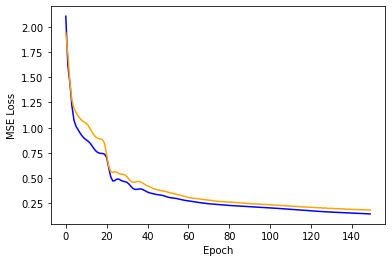

In [ ]:
train_loss = history.history['loss']
valdn_loss = history.history['val_loss']
plt.plot(np.arange(len(train_loss)), train_loss, color="blue")
plt.plot(np.arange(len(train_loss)), valdn_loss, color="orange")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

<b>Figure 2:</b> Training and Validation MSE loss (blue, orange) as a function of Epoch.

---

## 3. Testing the Model

Now that the model has been trained, testing the model is a computationally cheap proceedure. As before, we choose the data using DEMdata, and load with DataLoader. Using `valtest_model`, the DeepEM map is created, and the MSE loss calculated as during training.

In [ ]:

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)


1/1 - 0s - loss: 0.2456 - accuracy: 0.6616 - 153ms/epoch - 153ms/step


In [ ]:
t0 = time.time()  # Timing how long it takes to predict the DEMs
dem_pred = model.predict(X_test)
performance = "Number of DEM solutions per second = {0}".format(
    (y_test.shape[2] * y_test.shape[3]) / (time.time() - t0)
)

In [ ]:
print(performance)

Number of DEM solutions per second = 39895.001361322145


In [ ]:
dem_pred.shape

(1, 512, 512, 18)

#### Plotting: AIA, Basis Pursuit, DeepEM 

With the DeepEM map calculated, we can now compare the solutions obtained by Basis Pursuit and DeepEM. Figure 3 is similar to Figure 1 with an additional row corresponding to the solutions for DeepEM. Figure 3 shows <i>SDO</i>/AIA images in 171 Å, 211 Å, and 94 Å (left, top to bottom), with the corresponding DEM bins from Basis Pursuit (chosen at the peak sensitivity of each of the <i>SDO</i>/AIA channels) shown in the middle (top to bottom). The right-hand column row shows the DeepEM solutions that correspond to the same bins as the Basis Pursuit solutions. DeepEM provides solutions that are similar to Basis Pursuit, but importantly, provides DEM solutions for every pixel.

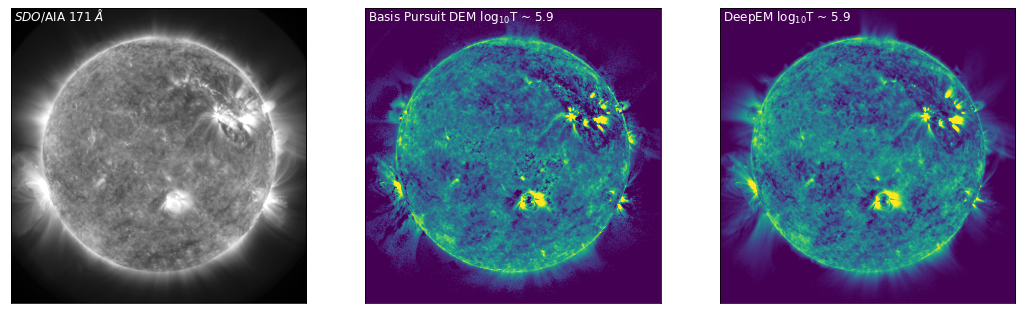

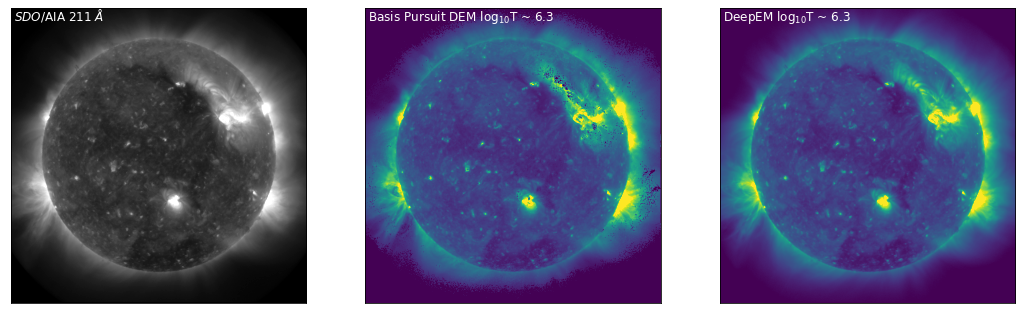

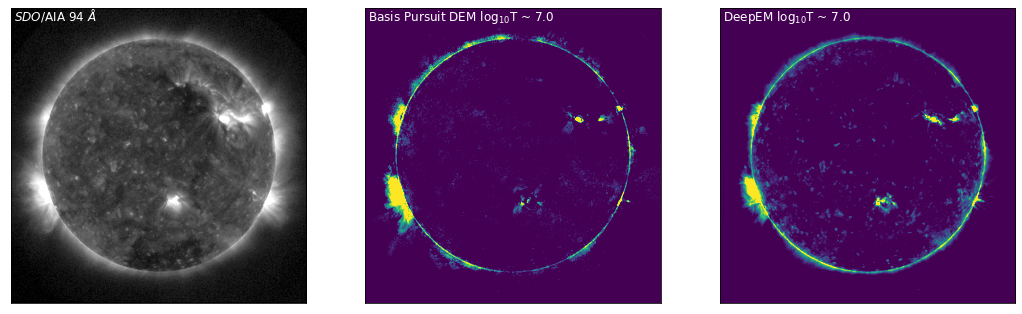

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(9 * 2, 9))

ax[0].imshow(X_test[0, :, :, 2], vmin=0.01, vmax=30, cmap="Greys_r", origin="lower")
ax[0].text(5, 490, "${\it SDO}$/AIA 171 $\AA$", color="white", size="large")
ax[1].imshow(
    y_test[0,:, :, 4],
    vmin=0.01,
    vmax=3,
    cmap="viridis",
    origin="lower",
)
ax[1].text(5, 490, "Basis Pursuit DEM log$_{10}$T ~ 5.9", color="white", size="large")
ax[2].imshow(
    dem_pred[0, :, :, 4],
    vmin=0.01,
    vmax=3,
    cmap="viridis",
    origin="lower",
)
ax[2].text(5, 490, "DeepEM log$_{10}$T ~ 5.9", color="white", size="large")

for axes in ax:
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)

fig, ax = plt.subplots(ncols=3, figsize=(9 * 2, 9))

ax[0].imshow(X_test[0, :, :, 4], vmin=0.25, vmax=25, cmap="Greys_r", origin="lower")
ax[0].text(5, 490, "${\it SDO}$/AIA 211 $\AA$", color="white", size="large")
ax[1].imshow(
    y_test[0, :, :, 8],
    vmin=0.25,
    vmax=10,
    cmap="viridis",
    origin="lower",
)
ax[1].text(5, 490, "Basis Pursuit DEM log$_{10}$T ~ 6.3", color="white", size="large")
ax[2].imshow(
    dem_pred[0, :, :, 8],
    vmin=0.25,
    vmax=10,
    cmap="viridis",
    origin="lower",
)
ax[2].text(5, 490, "DeepEM log$_{10}$T ~ 6.3", color="white", size="large")

for axes in ax:
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)

fig, ax = plt.subplots(ncols=3, figsize=(9 * 2, 9))

ax[0].imshow(X_test[0, :, :, 0], vmin=0.01, vmax=3, cmap="Greys_r", origin="lower")
ax[0].text(5, 490, "${\it SDO}$/AIA 94 $\AA$", color="white", size="large")
ax[1].imshow(
    y_test[0, :, :, 14],
    vmin=0.01,
    vmax=3,
    cmap="viridis",
    origin="lower",
)
ax[1].text(5, 490, "Basis Pursuit DEM log$_{10}$T ~ 7.0", color="white", size="large")
ax[2].imshow(
    dem_pred[0, :, :, 14],
    vmin=0.01,
    vmax=3,
    cmap="viridis",
    origin="lower",
)
ax[2].text(5, 490, "DeepEM log$_{10}$T ~ 7.0", color="white", size="large")

for axes in ax:
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)

<b>Figure 3</b>: Left to Right: <i>SDO</i>/AIA images in 171 Å, 211 Å, and 94 Å (left, top to bottom), with the corresponding DEM bins from Basis Pursuit (chosen at the peak sensitivity of each of the <i>SDO</i>/AIA channels) shown below (middle, top to bottom). The right-hand column shows the DeepEM solutions that correspond to the same bins as the Basis Pursuit solutions. DeepEM provides solutions that are similar to Basis Pursuit, but importantly, provides DEM solutions for every pixel.



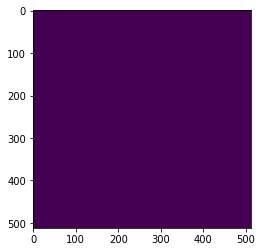

In [ ]:
plt.imshow(status[2])


---

Furthermore, as we have the original Basis Pursuit DEM solutions ("the ground truth"), we can compare the average DEM from Basis Pursuit to the average DEM from DeepEM, as they should be similar. Figure 4 shows the average Basis Pursuit DEM (black curve) and the DeepEM solution (dashed line).

In [ ]:
def PlotTotalEM(em_unscaled, em_pred_unscaled, lgtaxis, status):
    mask = np.zeros([status.shape[0], status.shape[1]])
    mask[np.where(status == 0.0)] = 1.0
    nmask = np.sum(mask)

    EM_tru_sum = np.zeros([lgtaxis.size])
    EM_inv_sum = np.zeros([lgtaxis.size])

    for i in range(lgtaxis.size):
        EM_tru_sum[i] = np.sum(em_unscaled[0, :, :, i] * mask) / nmask
        EM_inv_sum[i] = np.sum(em_pred_unscaled[0, :, :, i] * mask) / nmask

    fig = plt.figure
    plt.plot(lgtaxis, EM_tru_sum, linewidth=3, color="black")
    plt.plot(lgtaxis, EM_inv_sum, linewidth=3, color="lightblue", linestyle="--")
    plt.tick_params(axis="both", which="major")  # , labelsize=16)
    plt.tick_params(axis="both", which="minor")  # , labelsize=16)

    dlogT = lgtaxis[1] - lgtaxis[0]

    plt.xlim(lgtaxis[0] - 0.5 * dlogT, lgtaxis.max() + 0.5 * dlogT)
    plt.xticks(np.arange(np.min(lgtaxis), np.max(lgtaxis), 2 * dlogT))
    plt.ylim(1e24, 1e27)
    plt.yscale("log")
    plt.xlabel("log$_{10}$T [K]")
    plt.ylabel("Mean Emission Measure [cm$^{-5}$]")

    plt.show()
    return EM_inv_sum, EM_tru_sum

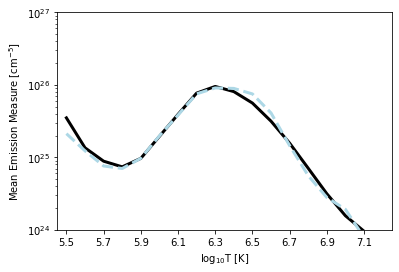

In [ ]:
em_unscaled = em_unscale(y_test)
em_pred_unscaled = em_unscale(dem_pred)

# Status for the test data. While DeepEM was trained on all examples in the training set,
# we only compare the DEMs where Basis Pursuit obtained a solution (status = 0)
#status = status[2, :, :]

EMinv, EMTru = PlotTotalEM(em_unscaled, em_pred_unscaled, lgtaxis, status)

<b>Figure 4</b>: Average Basis Pursuit DEM (plotted as mean emission measure, black line) and the Average DeepEM solution (dashed line). It is clear that this simple implementation of DeepEM provides, on average, DEMs that are similar to Basis Pursuit (Cheung <i>et al</i> 2015).

---

## 4. Synthesize <i>SDO</i>/AIA Observations

Finally, it is also of interest to reconstruct the <i>SDO</i>/AIA observations from both the Basis Pursuit, and DeepEM solutions. 

We are able to pose the problem of reconstructing the <i>SDO</i>/AIA observations from the DEM as a 1x1 2D Convolution. We first define the weights as the response functions of each channel, and set the biases to $zero$. By convolving the unscaled DEM at each pixel with the 6 filters (one for each <i>SDO</i>/AIA response function), we can recover the <i>SDO</i>/AIA observations.

In [ ]:
# We first load the AIA response functions:
cl = np.load(os.path.join(dir, "AIA_Resp.npy"))

In [ ]:
# Used Conv2d to convolve?? every pixel (18x1x1) by the 6 response functions
# to return a set of observed fluxes in each channel (6x1x1)
dem2aia = cudaize(nn.Conv2d(18, 6, kernel_size=1))

chianti_lines_2 = cudaize(torch.zeros(6, 18, 1, 1))
biases = cudaize(torch.zeros(6))

# set the weights to each of the SDO/AIA response functions and biases to zero
for i, p in enumerate(dem2aia.parameters()):
    if i == 0:
        p.data = Variable(cudaize(torch.from_numpy(cl).type(torch.FloatTensor)))
    else:
        p.data = biases

In [ ]:
AIA_out = img_scale(dem2aia(Variable(em_unscale(dem_in_test))).detach().cpu().numpy())
AIA_out_DeepEM = img_scale(
    dem2aia(Variable(em_unscale(dem_pred))).detach().cpu().numpy()
)

#### Plotting SDO/AIA Observations and Synthetic Observations

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(9 * 2, 9))

ax[0].imshow(X_test[0, 2, :, :], vmin=0.01, vmax=30, cmap="Greys_r", origin="lower")
ax[0].text(5, 490, "${\it SDO}$/AIA 171 $\AA$", color="white", size="large")
ax[1].imshow(AIA_out[0, 2, :, :], vmin=0.01, vmax=30, cmap="Greys_r", origin="lower")
ax[1].text(5, 490, "Basis Pursuit Synthesized 171 $\AA$", color="white", size="large")
ax[2].imshow(
    AIA_out_DeepEM[0, 2, :, :], vmin=0.01, vmax=30, cmap="Greys_r", origin="lower"
)
ax[2].text(5, 490, "DeepEM Synthesized 171 $\AA$", color="white", size="large")

for axes in ax:
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)

fig, ax = plt.subplots(ncols=3, figsize=(9 * 2, 9))

ax[0].imshow(X_test[0, 4, :, :], vmin=0.25, vmax=25, cmap="Greys_r", origin="lower")
ax[0].text(5, 490, "${\it SDO}$/AIA 211 $\AA$", color="white", size="large")
ax[1].imshow(AIA_out[0, 4, :, :], vmin=0.25, vmax=25, cmap="Greys_r", origin="lower")
ax[1].text(5, 490, "Basis Pursuit Synthesized 211 $\AA$", color="white", size="large")
ax[2].imshow(
    AIA_out_DeepEM[0, 4, :, :], vmin=0.25, vmax=25, cmap="Greys_r", origin="lower"
)
ax[2].text(5, 490, "DeepEM Synthesized 211 $\AA$", color="white", size="large")

for axes in ax:
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)

fig, ax = plt.subplots(ncols=3, figsize=(9 * 2, 9))

ax[0].imshow(X_test[0, 0, :, :], vmin=0.01, vmax=3, cmap="Greys_r", origin="lower")
ax[0].text(5, 490, "${\it SDO}$/AIA 94 $\AA$", color="white", size="large")
ax[1].imshow(AIA_out[0, 0, :, :], vmin=0.01, vmax=3, cmap="Greys_r", origin="lower")
ax[1].text(5, 490, "Basis Pursuit Synthesized 94 $\AA$", color="white", size="large")
ax[2].imshow(
    AIA_out_DeepEM[0, 0, :, :], vmin=0.01, vmax=3, cmap="Greys_r", origin="lower"
)
ax[2].text(5, 490, "DeepEM Synthesized 94 $\AA$", color="white", size="large")

for axes in ax:
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)

<b>Figure 5:</b> Top to Bottom: <i>SDO</i>/AIA images in 171 Å, 211 Å, and 94 Å (left, top to bottom) with the corresponding synthesised observations from Basis Pursuit (middle, top to bottom) and DeepEM (right, top to bottom). DeepEM provides synthetic observations that are similar to Basis Pursuit, with the addition of solutions where the basis pursuit solution was $zero$.

---

## 5. Doing this on your data

There are two way in which you can use this notebook:

1. Train your own model: Instead of Basis Pursuit solutions (as used here), you could use your favourite inversion technique to generate the training data and then feed that into the training.

2. Directly use the pre-trained model we provide and perform inference on your AIA images.

#### Formats:

* Input: 6 x N x N (where 6 is the number of input AIA/SDO channels) as .npy file
* Output: Nt x N x N (where Nt is the number of temperature bins, 18 in our case)

where N x N is the size of the image (assumed to be square).

## 6. Discussion

This notebook has provided a simple example of how a 1x1 2D Convolutional Neural Network can be used to improve computational cost for DEM inversion. Future development of DeepEM is on-going, and this notebook can be improved in a few ways:

1. By using both the original, and synthesised data from the DEM, the ability of the DEM to recover the original or supplementary data (such as spectroscopic EUV data) can be used as an additional term in the loss function. 

2. This implementation of DeepEM has been trained on a <i>single</i> set of observations. While there are 512$^{2}$ DEMs in one set of observations, it would be advisable to train the model to further images of the Sun in various states of activity including times of solar flaring.

3. For simplicity this implementation of DeepEM has been trained on every single pixel in the training set with no with no regards to the quality or existence of the solution. If trained for enough Epochs, DeepEM will start to remember which combinations of AIA values lead to DEMs equal to zero in the original training set. By utilising the status files included in this notebook it would be advisable to only train DeepEM on pixels where the solutions exist.

---

# Second model with Dropout

In [ ]:
class MonteCarloDropout(Dropout):
  def call(self, inputs):
    return super().call(inputs, training=True)

In [ ]:
reg = tf.keras.regularizers.l2(l2=1e-9)

kwargs = {'kernel_size': 1} #, 'activation': 'relu'}#, 'kernel_regularizer': reg }

model = Sequential([
    InputLayer(input_shape=(512, 512, 6)),
    Conv2D(300, **kwargs),
    LeakyReLU(alpha=1e-2),
    MonteCarloDropout(0.2),
    Conv2D(300, **kwargs ),
    LeakyReLU(alpha=1e-2),
    MonteCarloDropout(0.2),
    Conv2D(18, **kwargs),
    LeakyReLU(alpha=1e-2) ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 300)     2100      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512, 512, 300)     0         
                                                                 
 monte_carlo_dropout (MonteC  (None, 512, 512, 300)    0         
 arloDropout)                                                    
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 512, 300)     90300     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512, 512, 300)     0         
                                                                 
 monte_carlo_dropout_1 (Mont  (None, 512, 512, 300)    0         
 eCarloDropout)                                         

In [ ]:
optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-6)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, verbose=0,
    restore_best_weights=True
)


model.compile(optimizer=optimizer,
              loss='MSE')

In [ ]:
 with tf.device('/device:GPU:0'):

   history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                       epochs=150, verbose=0, callbacks=[early_stopping])


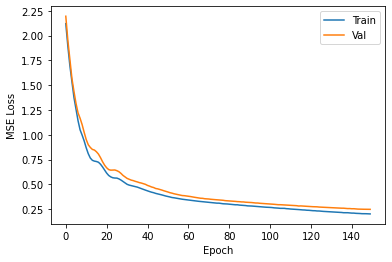

In [ ]:
train_loss = history.history['loss']
valdn_loss = history.history['val_loss']
plt.plot(np.arange(len(train_loss)), train_loss, label='Train')
plt.plot(np.arange(len(train_loss)), valdn_loss, label='Val')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

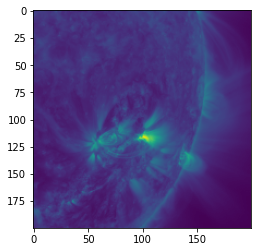

In [ ]:
plt.imshow(X_test[0,200:400,300:500,2])

In [ ]:
n_preds = 100
pred = []
for i in range(n_preds):
  #pred.append(model(x_pred, training=True))
  pred.append(model.predict(X_test))

In [ ]:
def PlotTotalEM(em_unscaled, em_pred_unscaled, lgtaxis, status):
    mask = np.zeros([status.shape[0], status.shape[1]])
    mask[np.where(status == 0.0)] = 1.0
    nmask = np.sum(mask)

    EM_tru_sum = np.zeros([lgtaxis.size])
    EM_inv_sum = np.zeros([lgtaxis.size])

    for i in range(lgtaxis.size):
        EM_tru_sum[i] = np.sum(em_unscaled[0, :, :, i] * mask) / nmask
        EM_inv_sum[i] = np.sum(np.median(em_pred_unscaled[:, 0, :, :, i], axis=0) * mask) / nmask

    fig = plt.figure
    plt.plot(lgtaxis, EM_tru_sum, linewidth=3, color="black", label='BP')
    plt.plot(lgtaxis, EM_inv_sum, linewidth=3, color="lightblue", linestyle="--", label='NN')
    plt.tick_params(axis="both", which="major")  # , labelsize=16)
    plt.tick_params(axis="both", which="minor")  # , labelsize=16)

    dlogT = lgtaxis[1] - lgtaxis[0]

    plt.xlim(lgtaxis[0] - 0.5 * dlogT, lgtaxis.max() + 0.5 * dlogT)
    plt.xticks(np.arange(np.min(lgtaxis), np.max(lgtaxis), 2 * dlogT))
    plt.ylim(1e24, 1e27)
    plt.yscale("log")
    plt.xlabel("log$_{10}$T [K]")
    plt.ylabel("Mean Emission Measure [cm$^{-5}$]")
    plt.legend()
    plt.show()
    return EM_inv_sum, EM_tru_sum

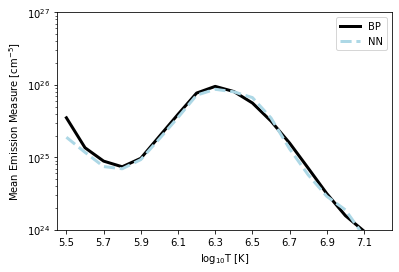

In [ ]:
em_unscaled = em_unscale(y_test)
em_pred_unscaled = em_unscale(np.array(pred))

# Status for the test data. While DeepEM was trained on all examples in the training set,
# we only compare the DEMs where Basis Pursuit obtained a solution (status = 0)
status2 = status[2, :, :].copy()

EMinv, EMTru = PlotTotalEM(em_unscaled, em_pred_unscaled, lgtaxis, status2)

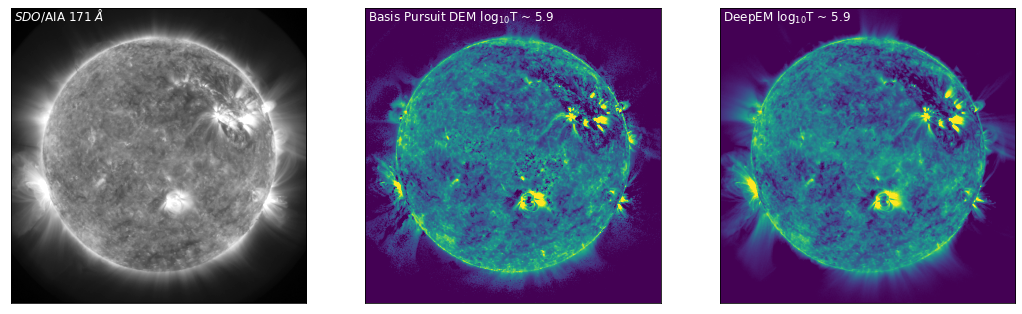

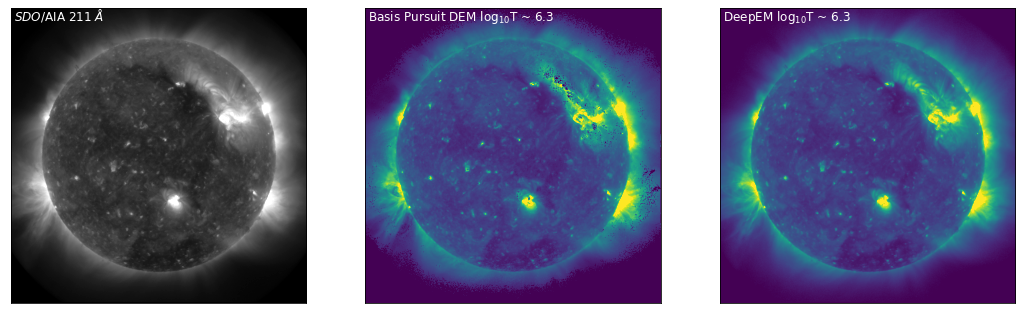

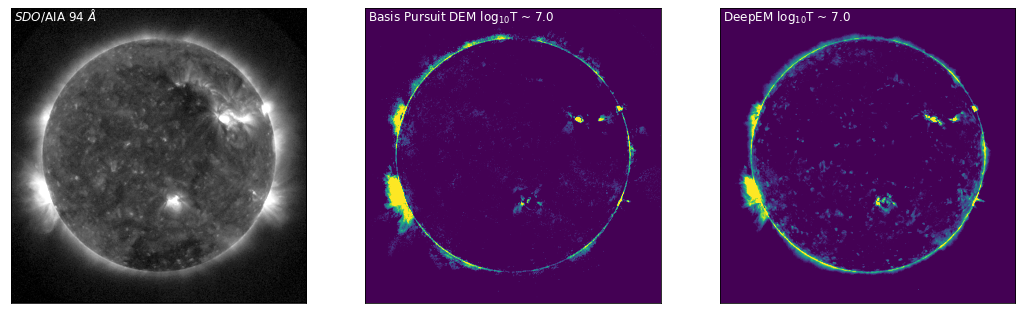

In [ ]:
dem_pred = np.median(np.array(pred), axis=0)

fig, ax = plt.subplots(ncols=3, figsize=(9 * 2, 9))

ax[0].imshow(X_test[0, :, :, 2], vmin=0.01, vmax=30, cmap="Greys_r", origin="lower")
ax[0].text(5, 490, "${\it SDO}$/AIA 171 $\AA$", color="white", size="large")
ax[1].imshow(
    y_test[0,:, :, 4],
    vmin=0.01,
    vmax=3,
    cmap="viridis",
    origin="lower",
)
ax[1].text(5, 490, "Basis Pursuit DEM log$_{10}$T ~ 5.9", color="white", size="large")
ax[2].imshow(
    dem_pred[0, :, :, 4],
    vmin=0.01,
    vmax=3,
    cmap="viridis",
    origin="lower",
)
ax[2].text(5, 490, "DeepEM log$_{10}$T ~ 5.9", color="white", size="large")

for axes in ax:
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)

fig, ax = plt.subplots(ncols=3, figsize=(9 * 2, 9))

ax[0].imshow(X_test[0, :, :, 4], vmin=0.25, vmax=25, cmap="Greys_r", origin="lower")
ax[0].text(5, 490, "${\it SDO}$/AIA 211 $\AA$", color="white", size="large")
ax[1].imshow(
    y_test[0, :, :, 8],
    vmin=0.25,
    vmax=10,
    cmap="viridis",
    origin="lower",
)
ax[1].text(5, 490, "Basis Pursuit DEM log$_{10}$T ~ 6.3", color="white", size="large")
ax[2].imshow(
    dem_pred[0, :, :, 8],
    vmin=0.25,
    vmax=10,
    cmap="viridis",
    origin="lower",
)
ax[2].text(5, 490, "DeepEM log$_{10}$T ~ 6.3", color="white", size="large")

for axes in ax:
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)

fig, ax = plt.subplots(ncols=3, figsize=(9 * 2, 9))

ax[0].imshow(X_test[0, :, :, 0], vmin=0.01, vmax=3, cmap="Greys_r", origin="lower")
ax[0].text(5, 490, "${\it SDO}$/AIA 94 $\AA$", color="white", size="large")
ax[1].imshow(
    y_test[0, :, :, 14],
    vmin=0.01,
    vmax=3,
    cmap="viridis",
    origin="lower",
)
ax[1].text(5, 490, "Basis Pursuit DEM log$_{10}$T ~ 7.0", color="white", size="large")
ax[2].imshow(
    dem_pred[0, :, :, 14],
    vmin=0.01,
    vmax=3,
    cmap="viridis",
    origin="lower",
)
ax[2].text(5, 490, "DeepEM log$_{10}$T ~ 7.0", color="white", size="large")

for axes in ax:
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)

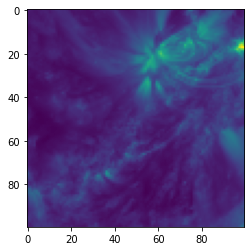

In [ ]:
plt.imshow(X_test[0,300:400,300:400,2])

In [ ]:
"""
This code was taken form the PyMC library https://github.com/pymc-devs/pymc
"""

import numpy as np

def calc_min_interval(x, alpha):
    """Internal method to determine the minimum interval of a given width
    Assumes that x is sorted numpy array.
    """

    n = len(x)
    cred_mass = 1.0-alpha

    interval_idx_inc = int(np.floor(cred_mass*n))
    n_intervals = n - interval_idx_inc
    interval_width = x[interval_idx_inc:] - x[:n_intervals]

    if len(interval_width) == 0:
        raise ValueError('Too few elements for interval calculation')

    min_idx = np.argmin(interval_width)
    hdi_min = x[min_idx]
    hdi_max = x[min_idx+interval_idx_inc]
    return hdi_min, hdi_max


def hpd(x, alpha=0.05):
    """Calculate highest posterior density (HPD) of array for given alpha. 
    The HPD is the minimum width Bayesian credible interval (BCI).
    :Arguments:
        x : Numpy array
        An array containing MCMC samples
        alpha : float
        Desired probability of type I error (defaults to 0.05)
    """

    # Make a copy of trace
    x = x.copy()
    # For multivariate node
    if x.ndim > 1:
        # Transpose first, then sort
        tx = np.transpose(x, list(range(x.ndim))[1:]+[0])
        dims = np.shape(tx)
        # Container list for intervals
        intervals = np.resize(0.0, dims[:-1]+(2,))

        for index in make_indices(dims[:-1]):
            try:
                index = tuple(index)
            except TypeError:
                pass

            # Sort trace
            sx = np.sort(tx[index])
            # Append to list
            intervals[index] = calc_min_interval(sx, alpha)
        # Transpose back before returning
        return np.array(intervals)
    else:
        # Sort univariate node
        sx = np.sort(x)
        return np.array(calc_min_interval(sx, alpha))

In [ ]:
coord_list = [[325, 360], # AR
              [360, 340]] # QS

n_coords = len(coord_list)
hdi_min= np.zeros((n_coords, 18))
hdi_max= np.zeros((n_coords, 18))

pred_arr = np.array(pred)
for j, coord in enumerate(coord_list):
  dem_pix = np.squeeze(pred_arr[:, 0, coord[0], coord[1],:])
  for i in range(18):
    hdi_min[j, i], hdi_max[j, i] = hpd(dem_pix[:, i])

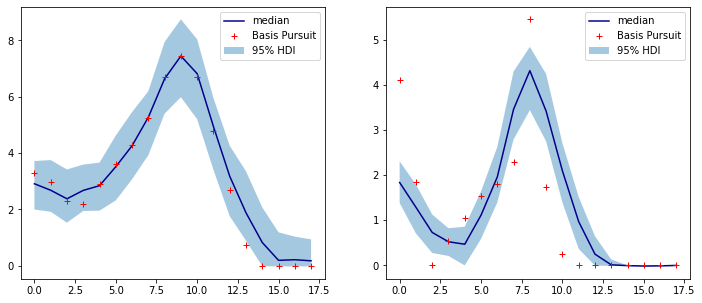

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,5))


for i, (axi, coord) in enumerate(zip(fig.axes, coord_list)):
  dem_pix = np.squeeze(pred_arr[:, 0, coord[0], coord[1],:])
  axi.plot(np.mean(dem_pix, axis=0), color='darkblue', label='median')
  axi.fill_between(np.arange(18), hdi_min[i], hdi_max[i], alpha=0.4, label='95% HDI')
  axi.plot(y_test[0,coord[0], coord[1],:], 'r+', label = 'Basis Pursuit')
  axi.legend()

# Model 3

In [21]:
from astroNN.nn.losses import mse_lin_wrapper, mse_var_wrapper, robust_mse
import random

In [22]:
class MonteCarloDropout(Dropout):
  def call(self, inputs):
    return super().call(inputs, training=True)

In [27]:
def model_dropout_var(num_hidden, dropout_rate, l2_rate):
  kwargs = {'kernel_size': 1} #, 'activation': 'relu'}#, 'kernel_regularizer': reg }
  input_tensor = tfk.layers.Input(batch_shape=(None,512, 512, 6), name='input')
  labels_err_tensor = tfk.layers.Input(batch_shape=(None, 6), name='label_err')
  layer_1 = Conv2D(num_hidden, **kwargs)(input_tensor)
  act_layer = LeakyReLU(alpha=1e-2)(layer_1)
  layer_2 = MonteCarloDropout(dropout_rate)(act_layer)
  layer_3 = Conv2D(num_hidden, **kwargs)(layer_2)
  act_layer = LeakyReLU(alpha=1e-2)(layer_3)
  layer_4 = MonteCarloDropout(dropout_rate)(act_layer)
  layer_5 = Conv2D(18, **kwargs)(layer_4)
  output = LeakyReLU(alpha=1e-2, name='output')(layer_5)

  # Data-dependent uncertainty outainty
  variance_output = Dense(units=1, activation='linear', name='variance_output')(layer_5)
    
  #model = Model(inputs=[input_tensor, labels_err_tensor], outputs=[variance_output, output])
  model = Model(inputs=[input_tensor], outputs=[output])
  model_prediction = Model(inputs=input_tensor, outputs=[output])
    
  mse_var_ext = mse_var_wrapper(output, labels_err_tensor)
  mse_lin_ext = mse_lin_wrapper(variance_output, labels_err_tensor)

  return model, model_prediction, mse_lin_ext, mse_var_ext


In [28]:
#Define some parameter
dropout_rate = 0.3
l2_rate = 1e-5
optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=l2_rate)

# Compile Keras model
num_hidden = 300
model, model_prediction, mse_lin_ext, mse_var_ext = model_dropout_var(num_hidden, dropout_rate, l2_rate)
#model.compile(loss='{'output': mse_lin_ext, 'variance_output': mse_var_ext}', optimizer=optimizer,
 #                                    loss_weights={'output': .5, 'variance_output': .5})
model.compile(loss='mse', optimizer=optimizer)

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 512, 512, 6)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 512, 300)     2100      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512, 512, 300)     0         
                                                                 
 monte_carlo_dropout (MonteC  (None, 512, 512, 300)    0         
 arloDropout)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 512, 512, 300)     90300     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512, 512, 300)     0         
                                                             

In [56]:
def generate_train_batch(x, y):
    while True:
        indices = random.sample(range(0, x.shape[0]), batch_size)
        indices = np.sort(indices)
        x_batch, y_batch, y_err_batch = x[indices], y[indices], np.zeros(batch_size)
        yield ({'input': x_batch, 'label_err': y_err_batch}, {'output': y_batch, 'variance_output': y_batch})

In [30]:
batch_size = 64

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, verbose=0,
    restore_best_weights=True
)

with tf.device('/device:GPU:0'):
   #history = model.fit_generator(generator=generate_train_batch(X_train, y_train), epochs=150, verbose=0, 
   #                 steps_per_epoch= X_train.shape[0] // batch_size)
   history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150, verbose=1, callbacks=[early_stopping])


Epoch 1/150
1/1 [==============================] - 12s 12s/step - loss: 2.0042 - val_loss: 1.9847
Epoch 2/150
1/1 [==============================] - 1s 587ms/step - loss: 1.6737 - val_loss: 1.7256
Epoch 3/150
1/1 [==============================] - 1s 584ms/step - loss: 1.4462 - val_loss: 1.5460
Epoch 4/150
1/1 [==============================] - 1s 584ms/step - loss: 1.2995 - val_loss: 1.4980
Epoch 5/150
1/1 [==============================] - 1s 584ms/step - loss: 1.2719 - val_loss: 1.4594
Epoch 6/150
1/1 [==============================] - 1s 586ms/step - loss: 1.2485 - val_loss: 1.3556
Epoch 7/150
1/1 [==============================] - 1s 586ms/step - loss: 1.1644 - val_loss: 1.2182
Epoch 8/150
1/1 [==============================] - 1s 581ms/step - loss: 1.0446 - val_loss: 1.0830
Epoch 9/150
1/1 [==============================] - 1s 584ms/step - loss: 0.9287 - val_loss: 0.9925
Epoch 10/150
1/1 [==============================] - 1s 587ms/step - loss: 0.8548 - val_loss: 0.9561
Epoch 11/1

In [ ]:
def PlotTotalEM(em_unscaled, em_pred_unscaled, lgtaxis, status):
    mask = np.zeros([status.shape[0], status.shape[1]])
    mask[np.where(status == 0.0)] = 1.0
    nmask = np.sum(mask)

    EM_tru_sum = np.zeros([lgtaxis.size])
    EM_inv_sum = np.zeros([lgtaxis.size])

    for i in range(lgtaxis.size):
        EM_tru_sum[i] = np.sum(em_unscaled[0, :, :, i] * mask) / nmask
        EM_inv_sum[i] = np.sum(np.median(em_pred_unscaled[:, 0, :, :, i], axis=0) * mask) / nmask

    fig = plt.figure
    plt.plot(lgtaxis, EM_tru_sum, linewidth=3, color="black", label='BP')
    plt.plot(lgtaxis, EM_inv_sum, linewidth=3, color="lightblue", linestyle="--", label='NN')
    plt.tick_params(axis="both", which="major")  # , labelsize=16)
    plt.tick_params(axis="both", which="minor")  # , labelsize=16)

    dlogT = lgtaxis[1] - lgtaxis[0]

    plt.xlim(lgtaxis[0] - 0.5 * dlogT, lgtaxis.max() + 0.5 * dlogT)
    plt.xticks(np.arange(np.min(lgtaxis), np.max(lgtaxis), 2 * dlogT))
    plt.ylim(1e24, 1e27)
    plt.yscale("log")
    plt.xlabel("log$_{10}$T [K]")
    plt.ylabel("Mean Emission Measure [cm$^{-5}$]")
    plt.legend()
    plt.show()
    return EM_inv_sum, EM_tru_sum

In [31]:

mc_dropout_num = 100
predictions = np.zeros((mc_dropout_num, 512, 512, 18))


for i in range(mc_dropout_num):
    result = np.array(model_prediction.predict(X_test))
    predictions[i] = result
    

length_sacle = 10.0
inverse_model_precision = (2 * X_train.shape[0] * l2_rate) / (length_sacle**2. * (1 - dropout_rate))

In [76]:
model_prediction.predict(X_test[0:2,:]).shape

(2, 18)

In [72]:
X_test[0,:][np.newaxis,].shape

(1, 6)